In [26]:
from matplotlib import pyplot as plt

from data.attribute import *

In [27]:
from data.selects import get_fors_selects
from data.population import get_bfs_population_cga

selects_df = get_fors_selects()
population_df = get_bfs_population_cga()

In [28]:
year = selects_df[YEAR_ATTR].max()
selects_year_df = selects_df[selects_df[YEAR_ATTR] == year]
population_year_df = population_df[population_df[YEAR_ATTR] == year]

year

np.uint16(2019)

<Axes: xlabel='Age'>

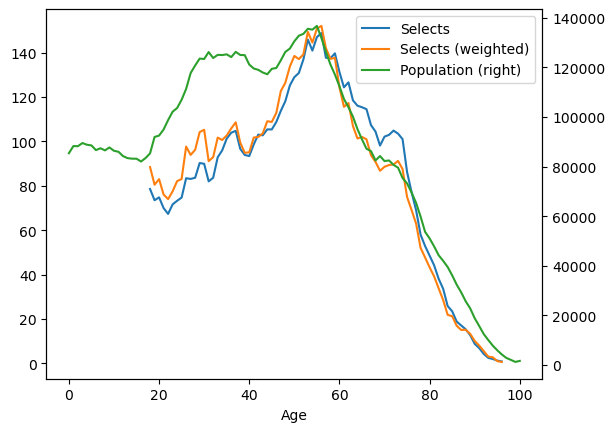

In [29]:
AVERAGE_YEARS = 5
selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weightc'].sum() \
    .rolling(AVERAGE_YEARS, center=True, min_periods=1).mean() \
    .rename('Selects')
weighted_selects_age = selects_year_df.groupby(AGE_ATTR) \
    ['weighttot'].sum() \
    .rolling(AVERAGE_YEARS, center=True, min_periods=1).mean() \
    .rename('Selects (weighted)')
population_age = population_year_df.groupby(AGE_ATTR)[POPULATION_ATTR].sum().rename('Population')

pd.concat(
    [selects_age, weighted_selects_age, population_age],
    axis=1
).sort_index().plot(secondary_y='Population')

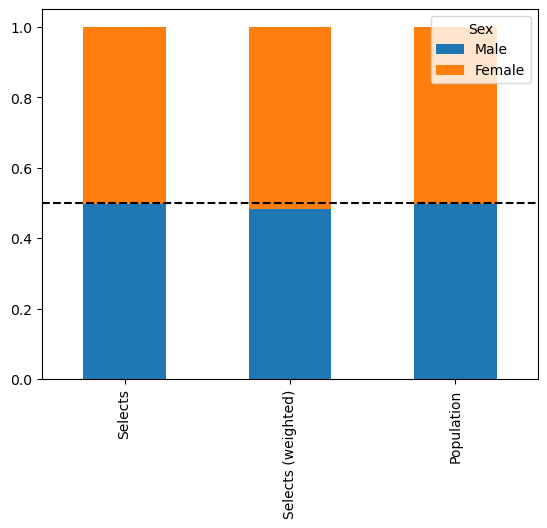

In [30]:
selects_sex = selects_year_df.groupby(SEX_ATTR) \
    ['weightc'].sum() \
    .rename('Selects')
weighted_selects_sex = selects_year_df.groupby(SEX_ATTR) \
    ['weighttot'].sum() \
    .rename('Selects (weighted)')
population_sex = population_year_df.groupby(SEX_ATTR)[POPULATION_ATTR].sum().rename('Population')

pd.concat(
    [p / p.sum() for p in (selects_sex, weighted_selects_sex, population_sex)],
    axis=1
).rename(SEX_LABEL_MAPPER).transpose().plot(kind='bar', stacked=True)
plt.axhline(0.5, color='black', linestyle='--')